# Decision Trees for Predicting Dengue Fever: Subgroup Assessment

**Abstract:** A decision tree was trained on tabular medical data (age, temperature, WBC exam score, Plt exam score) to predict whether or not patients had dengue fever. Datasets were split according to various features to assess the model's predictive stability. Dengue fever is a serious illness that is initially not easily detectable, and initial symptoms tend to be similar to those of the flu. The advantage of using decision trees to predict the existence dengue fever in patients, as opposed to using other machine learning methods, is the method can be easily understood by doctors and is easily interpretable.

## Theory

### Decision Trees

Decision trees, or Classification and Regression Trees (CART), are widely-used machine learning tools that involve successively separating a set of samples into subsets or nodes of a tree. Typically, each node is separated into two subsequent nodes until there are no samples left to separate, or until a max-depth is reached for the tree. The nodes are split based upon a condition or characteristic that influences the dependent variable the most for samples in that node. In training, the most influential conditions are determined for each node when the tree is constructed, thereby grouping similar samples together into nodes, with similarity increasing with each split, (i.e., with increasing depth of the tree). Each node is classified based upon the most common value for the dependent variable in that node, thereby giving the nodes predictive power over the samples grouped into them. After the tree is constructed, the conditions that were used to split the nodes of the training set can be applied to similar datasets to group similar samples together, after which predictions can be made for samples based upon their nodes.

Note that while sample similarity for nodes of the tree increase as the depth of the tree increases, a tree that is too deep will overfit and describe conditions specific only to the training set. Thus, controlling the max-depth of the tree is a technique used to prevent overfitting, thereby forcing the tree to model more general trends inherent in the data.

### Subgroups

#### n-Fold Cross Validation: Training Multiple Models

In n-fold cross validation, the overall dataset is split into equal parts for the purpose of training multiple models, such that all of the data is used at least once in a validation set. The confusion matrices (true negatives, false positives, false negatives, true positives) for each model are then added together to calculate the overall metrics of the model.

For this experiment, 5-fold cross validation was performed. The dataset was split into five equal subsets (each 20% of original dataset). The subsets were grouped into five validation sets (20% of original dataset) and five training sets (80% of original dataset, i.e., original dataset minus validation set). Five logistic regression models were trained and then assessed with corresponding validation sets. The resulting five confusion matrices were summed, producing an overall confusion matrix that would be used to calculate overall metrics.

#### Validation Subgroup Analysis

The validation datasets of each model were split into multiple subgroups based on various features, *(Age, Gender, Epidemic periods, Body Temp, White Blood Cells, Platelet, Comorbidities, coming to ER)*, to assess stability of the model accross datasets. The subgroup confusion matrices were summed across multiple models, resulting in overall confusion matrices for each subgroup. Confusion matrices were then used to calculate overall metrics for each subgroup.

## Setup


This notebook was originally written with the following versions:

    'R version 3.6.1 (2019-07-05)'
    'rpart 4.1.15'
    'rpart 4.1.15'
    'rpart.plot 3.0.8'
    'caTools 1.17.1.2'
    'caret 6.0.83'
    'data.table 1.12.2'
    'pROC 1.15.3'
    

In [1]:
# Check your versions
version$version.string;
paste("rpart", packageVersion("rpart"));
paste("rpart", packageVersion("rpart"));
paste("rpart.plot", packageVersion("rpart.plot"));
paste("caTools", packageVersion("caTools"));
paste("caret", packageVersion("caret"));
paste("data.table", packageVersion("data.table"));
paste("pROC", packageVersion("pROC"));

[1] "R version 3.6.1 (2019-07-05)"

[1] "rpart 4.1.15"

[1] "rpart 4.1.15"

[1] "rpart.plot 3.0.8"

[1] "caTools 1.17.1.2"

[1] "caret 6.0.83"

[1] "data.table 1.12.2"

[1] "pROC 1.15.3"

##### Prepare Notebook

In [2]:
# Import Libraries
library(rpart)
library(rpart.plot)
library(caTools)

library(caret)
library(data.table)
library(pROC)
# library(tidyverse)

# Data Information
# filename <- 'patient_year_vital_lab_exam_add-on_death_outcome_comorbidity_TCIC_dengue_suspected_bmi_ER_label_missing_mask.csv'
filename <- 'patients_cleaned.csv'
path <- '../mydata/'
pathfile <- paste(path,filename,sep='')

Loading required package: lattice
Loading required package: ggplot2
Registered S3 methods overwritten by 'ggplot2':
  method         from 
  [.quosures     rlang
  c.quosures     rlang
  print.quosures rlang
Type 'citation("pROC")' for a citation.

Attaching package: ‘pROC’

The following objects are masked from ‘package:stats’:

    cov, smooth, var



In [3]:
# View all CSV column names

# df <- read.csv(pathfile)
# names(df)

## Parameters

In [4]:
splits = 5 # number of folds for cross validation
recalls = c(0.85,0.90,0.95) # sensitivities used for calculating results


# Imported columns from CSV
desired_cols = c('age','sex','Temp','exam_WBC','exam_Plt', 'Opd_Visit_Date',
                'ER', 'Heart Disease', 'CVA', 'CKD', 'Severe Liver Disease', 
                'DM', 'Hypertension', 'Cancer without Metastasis', 'Cancer with Metastasis',
                'lab_result')

# Features used for training + dependent variable
train_cols = c('age','Temp','exam_WBC','exam_Plt','lab_result')


# Features used for creating validation subgroups (includes features from train_cols)
subgroup_cols = c('age','sex','Temp','exam_WBC','exam_Plt', 'week',
                'ER', 'Heart Disease', 'CVA', 'CKD', 'Severe Liver Disease', 
                'DM', 'Hypertension', 'Cancer without Metastasis', 'Cancer with Metastasis',
                'lab_result')

prior <- seq(0.1, 0.9, 0.008)

# Columns to be dropped after creating validation subgroups
# drop_cols = list(set(subgroup_cols) - set(train_cols))

## Data Preparation

In [5]:
# Create a dataframe with just train_cols as features
df <- read.csv(pathfile)
df <- df[,train_cols]
df <- as.data.frame(df)
# df <- cbind(index = as.numeric(row.names(df)), df) # adds indices?

# remove negative Temp values
df$Temp[which(df$Temp == -1)] <- NA

# remove rows with NA values
df <- na.omit(df)

# shuffle the df by row
df <- df[sample(nrow(df)),]

print(nrow(df))
head(df) # df[seq(6),]

[1] 4894


,age,Temp,exam_WBC,exam_Plt,lab_result
4226,58,37.9,14.2,272,False
2793,48,38.5,6.5,215,False
4859,32,39.6,5.1,161,True
4630,32,39.8,10.2,181,False
4516,66,38.2,2.2,141,True
1227,80,37.5,4.8,129,True


In [6]:
summary(df)

      age              Temp          exam_WBC         exam_Plt     lab_result  
 Min.   :  0.00   Min.   :34.80   Min.   : 0.600   Min.   :  2.0   False:1952  
 1st Qu.: 27.00   1st Qu.:37.50   1st Qu.: 4.000   1st Qu.:124.0   True :2942  
 Median : 47.00   Median :38.30   Median : 6.000   Median :169.0               
 Mean   : 46.82   Mean   :38.18   Mean   : 6.814   Mean   :171.1               
 3rd Qu.: 66.00   3rd Qu.:38.90   3rd Qu.: 8.500   3rd Qu.:216.0               
 Max.   :104.00   Max.   :41.30   Max.   :41.600   Max.   :976.0               

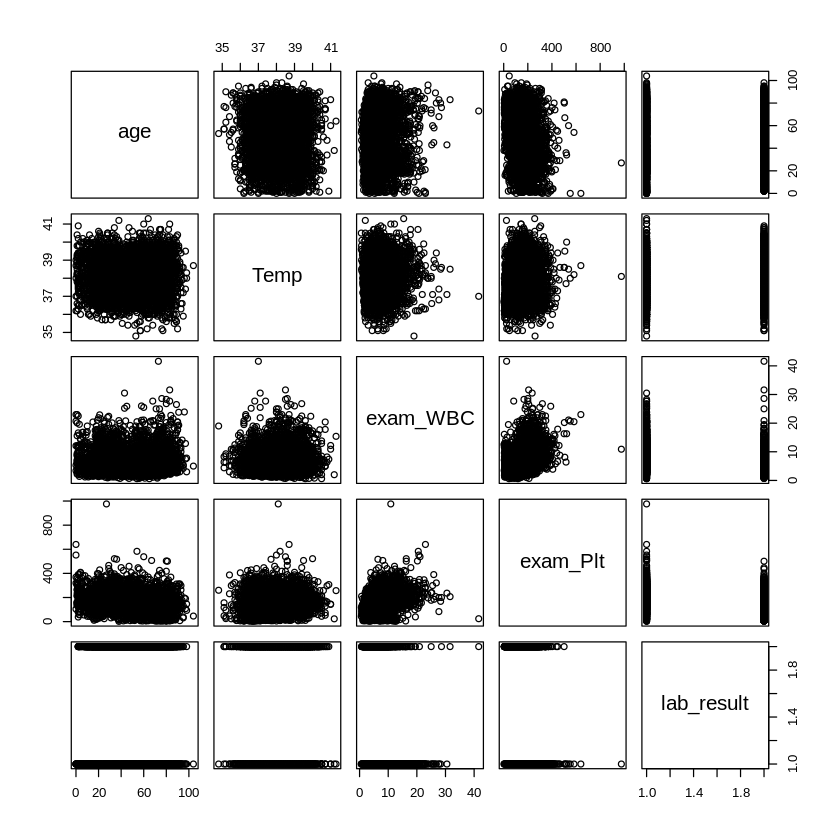

In [7]:
plot(df)

## Training

In [8]:
parms = 33
prior <- seq(0.1, 0.9, 0.008)
ncols = 14
result_table <- matrix(ncol=ncols) #matrix(NA, ncol = 282 ) # nrow(valid_df))

# for (i in prior)

flds <- createFolds(df$lab_result, k = splits, list = TRUE, returnTrain = FALSE) # separate df into subsets
for (i in 1:splits) {
    idx <- flds[[i]]
    train_df <- df[-idx,]
    valid_df <- df[idx,]
    dtreeM <- rpart(formula = lab_result ~ ., data = train_df, method = "class", 
        parms = list(prior = c(prior[parms], 1 - prior[parms])))
    cp <- dtreeM$cptable[which.min(dtreeM$cptable[, 3]), 1]
    dtreeM_pruned <- prune(dtreeM, cp = cp)
    preds <- predict(dtreeM_pruned, newdata = valid_df, type = "class")

#     print(mean(preds == valid_df[,5])) # accuracy
    
    accuracy = mean(preds == valid_df[,5])
    
    valid_result <- cbind(df[rownames(valid_df),], preds)
    
    # Confusion Matrix stuff
    FN <- nrow(subset(valid_result, (preds != lab_result) & (preds == 'False')))
    TN <- nrow(subset(valid_result, (preds == lab_result) & (preds == 'False')))
    FP <- nrow(subset(valid_result, (preds != lab_result) & (preds == 'True')))
    TP <- nrow(subset(valid_result, (preds == lab_result) & (preds == 'True')))
    size <- FN + TN + FP + TP
    
    PPV = if (TP+FP) TP / (TP + FP) else 0 # positive predict value
    NPV = if (TN+FN) TN / (TN + FN) else 0 # negative predict value
    F1 = 2*TP / (2*TP + FP + FN) #
    accuracy = (TP + TN) / (TP + TN + FP + FN)
    sensitivity = if (TP+FN) TP /(TP + FN) else 0 
    specificity = if (TN+FP) TN /(TN + FP) else 0 
    odds_ratio = if (FP*FN) (TP * TN) /(FP * FN) else 0
        
    model_num = i
    
    roc_obj <- roc(as.numeric(valid_df$lab_result), as.numeric(preds))
    roc_auc <- auc(roc_obj)
    
    model_metrics <- cbind(model_num, roc_auc, PPV, NPV, F1, accuracy, sensitivity, specificity, odds_ratio, FN, TN, FP, TP, size)
    
    result_table <- rbind(result_table, model_metrics)
    
#     toprint = paste(format(accuracy, digits=4), FN, TN, FP, TP, sep=" | ")
#     print(toprint)
    
#     result_table <- rbind(result_table, cbind(df[rownames(valid_df), ], 
#         result, validation = nrow(valid_df))) #rep(j, nrow(valid_df))))
    }
result_table <- result_table[-1,]

Setting levels: control = 1, case = 2
Setting direction: controls < cases
Setting levels: control = 1, case = 2
Setting direction: controls < cases
Setting levels: control = 1, case = 2
Setting direction: controls < cases
Setting levels: control = 1, case = 2
Setting direction: controls < cases
Setting levels: control = 1, case = 2
Setting direction: controls < cases
Setting levels: control = 1, case = 2
Setting direction: controls < cases
Setting levels: control = 1, case = 2
Setting direction: controls < cases
Setting levels: control = 1, case = 2
Setting direction: controls < cases
Setting levels: control = 1, case = 2
Setting direction: controls < cases
Setting levels: control = 1, case = 2
Setting direction: controls < cases


## Overall Results

In [9]:
# Combine Metrics -> Overall Metrics
overall <- data.frame(NA, stringsAsFactors=FALSE)
for(i in 2:14){
    overall <- cbind(overall, sum(result_table[,i]))
}
colnames(overall) <- (colnames(result_table))

FN = overall[1,10]
TN = overall[1,11]
FP = overall[1,12]
TP = overall[1,13]
size <- sum(FN,TN,FP,TP)

PPV = if (TP+FP) TP / (TP + FP) else 0 # positive predict value
NPV = if (TN+FN) TN / (TN + FN) else 0 # negative predict value
F1 = 2*TP / (2*TP + FP + FN) #
accuracy = (TP + TN) / (TP + TN + FP + FN)
sensitivity = if (TP+FN) TP /(TP + FN) else 0 
specificity = if (TN+FP) TN /(TN + FP) else 0 
odds_ratio = if (FP*FN) (TP * TN) /(FP * FN) else 0
model_num = NA


# roc_obj <- roc(as.numeric(valid_df$lab_result), as.numeric(preds))
# roc_auc <- auc(roc_obj)
roc_auc <- mean(result_table[1:splits,2])
# roc_auc <- simple_auc(sensitivity,1-specificity)
# roc_auc <- 0

overall <- cbind(model_num, roc_auc, PPV, NPV, F1, accuracy, sensitivity, specificity, odds_ratio, FN, TN, FP, TP, size)

result_table <- rbind(result_table, overall)

In [10]:
result_table

model_num,roc_auc,PPV,NPV,F1,accuracy,sensitivity,specificity,odds_ratio,FN,TN,FP,TP,size
1,0.7344322,0.7578348,0.7971014,0.8248062,0.7689162,0.9047619,0.5641026,12.29412,28,110,85,266,489
2,0.7789116,0.7879656,0.8652482,0.8553655,0.8102041,0.9353741,0.6224490,23.86202,19,122,74,275,490
3,0.7531920,0.7698864,0.8321168,0.8390093,0.7873211,0.9217687,0.5846154,16.58293,23,114,81,271,489
4,0.7482993,0.7738095,0.7792208,0.8253968,0.7755102,0.8843537,0.6122449,12.07430,34,120,76,260,490
5,0.7822344,0.7936047,0.8551724,0.8557994,0.8118609,0.9285714,0.6358974,22.70423,21,124,71,273,489
6,0.7788854,0.7981928,0.8152866,0.8466454,0.8036810,0.9013605,0.6564103,17.45754,29,128,67,265,489
7,0.7841373,0.8005952,0.8311688,0.8526149,0.8102041,0.9118644,0.6564103,19.76579,26,128,67,269,490
8,0.8054160,0.8285714,0.8103448,0.8571429,0.8220859,0.8877551,0.7230769,20.65152,33,141,54,261,489
9,0.7781834,0.7970149,0.8193548,0.8476190,0.8040816,0.9050847,0.6512821,17.80935,28,127,68,267,490
10,0.7583726,0.7794118,0.8053691,0.8359621,0.7873211,0.9013605,0.6153846,14.62069,29,120,75,265,489


In [12]:
round_df <- function(x, digits) {
    # round all numeric variables
    # x: data frame 
    # digits: number of digits to round
    y = x
    numeric_columns <- sapply(x, mode) == 'numeric'
    y[numeric_columns] <- round(x[numeric_columns], digits)
    y
}

round_df(result_table, 4)

model_num,roc_auc,PPV,NPV,F1,accuracy,sensitivity,specificity,odds_ratio,FN,TN,FP,TP,size
1,0.7344,0.7578,0.7971,0.8248,0.7689,0.9048,0.5641,12.2941,28,110,85,266,489
2,0.7789,0.7880,0.8652,0.8554,0.8102,0.9354,0.6224,23.8620,19,122,74,275,490
3,0.7532,0.7699,0.8321,0.8390,0.7873,0.9218,0.5846,16.5829,23,114,81,271,489
4,0.7483,0.7738,0.7792,0.8254,0.7755,0.8844,0.6122,12.0743,34,120,76,260,490
5,0.7822,0.7936,0.8552,0.8558,0.8119,0.9286,0.6359,22.7042,21,124,71,273,489
6,0.7789,0.7982,0.8153,0.8466,0.8037,0.9014,0.6564,17.4575,29,128,67,265,489
7,0.7841,0.8006,0.8312,0.8526,0.8102,0.9119,0.6564,19.7658,26,128,67,269,490
8,0.8054,0.8286,0.8103,0.8571,0.8221,0.8878,0.7231,20.6515,33,141,54,261,489
9,0.7782,0.7970,0.8194,0.8476,0.8041,0.9051,0.6513,17.8093,28,127,68,267,490
10,0.7584,0.7794,0.8054,0.8360,0.7873,0.9014,0.6154,14.6207,29,120,75,265,489
